## Jigsaw Agile Community Rules Classification

**Author:** Julien Sacko 

**Tech Stack:** PyTorch, TensorFlow, Hugging Face (Transformers, PEFT, TRL), vLLM, Optuna  

**Performance:** Top Tier | AUC: 0.884

### 📋 Executive Summary
This notebook documents an end-to-end Machine Learning pipeline designed to predict Reddit community rule violations. The solution addresses the challenge of interpreting unstructured, noisy user-generated content (UGC) by deploying a **Hybrid Ensemble** architecture.

**Key Engineering Highlights:**
1.  **Retrieval Augmented Generation (RAG):** Implemented a k-NN classifier using **Qwen-Embedding** to retrieve similar past violations from the training corpus, using the data itself as a dynamic knowledge base.
2.  **LLM Fine-Tuning:** Fine-tuned **Qwen 0.6B (Int8)** using **QLoRA** for reasoning-based classification.
3.  **Ensemble Optimization:** Used **Optuna** to find the optimal blend between the LLM, the RAG retriever, and a lightweight DeBERTa baseline.

## 1. Environment Setup & Configuration
To ensure reproducibility and performance in the Kaggle constrained environment (2x T4 GPUs), we utilize:
* **vLLM:** For state-of-the-art inference throughput.
* **DeepSpeed/Accelerate:** For efficient distributed training.
* **BitsAndBytes:** For 4-bit quantization (QLoRA) to fit LLMs into memory.

In [ ]:
!uv pip install --system --no-index --find-links='/kaggle/input/jigsaw-packages2/whls/' 'trl==0.21.0' 'optimum==1.27.0' 'auto-gptq==0.7.1' 'bitsandbytes==0.46.1' 'deepspeed==0.17.4' 'logits-processor-zoo==0.2.1' 'vllm==0.10.0'
!uv pip install --system --no-index --find-links='/kaggle/input/jigsaw-packages2/whls/' 'triton==3.2.0'
!uv pip install --system --no-index --find-links='/kaggle/input/jigsaw-packages2/whls/' 'clean-text'
!uv pip install --system --no-index -U --no-deps --find-links='/kaggle/input/jigsaw-packages2/whls/' 'peft' 'accelerate' 'datasets'

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import optuna
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
from nltk.corpus import stopwords
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from torch.optim import AdamW
from datasets import Dataset,DatasetDict, concatenate_datasets
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search, dot_score
from peft import PeftModel, PeftConfig
import torch.distributed as dist
from cleantext import clean
from tqdm.auto import tqdm
import vllm
from vllm.lora.request import LoRARequest
from logits_processor_zoo.vllm import MultipleChoiceLogitsProcessor
import random, numpy as np 
import pandas as pd 
from kaggle_secrets import UserSecretsClient
import multiprocessing as mp
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers.utils import is_torch_bf16_gpu_available
import os
import warnings
import gc
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

print("Setup complete")

2025-11-23 00:55:53.486729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763859353.703802      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763859353.771053      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete


In [44]:
COMPETITION = True # Skip experimentations
DATA_PATH = "/kaggle/input/jigsaw-agile-community-rules"

In [4]:
%%writefile constants_lora.py
EMBDEDDING_MODEL_PATH = "/kaggle/input/qwen-3-embedding/transformers/0.6b/1"
MODEL_OUTPUT_PATH = '/kaggle/input/qwen3-8b-embedding'
DATA_PATH = "/kaggle/input/jigsaw-agile-community-rules"

# https://huggingface.co/Qwen/Qwen3-Embedding-0.6B/blob/main/config_sentence_transformers.json
EMBEDDING_MODEL_QUERY = "Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery:"

CLEAN_TEXT = True
TOP_K = 1000
BATCH_SIZE = 128
BASE_MODEL_PATH = "/kaggle/input/qwen-3/transformers/0.6b-gptq-int8/1"
LORA_PATH = "output/"
POSITIVE_ANSWER = "Yes"
NEGATIVE_ANSWER = "No"
COMPLETE_PHRASE = "Answer:"
BASE_PROMPT = '''You are given a comment from reddit and a rule. Your task is to classify whether the comment violates the rule. Only respond Yes/No.'''

Overwriting constants_lora.py


## 2. Data Strategy & Exploratory Analysis (EDA)
The dataset consists of Reddit comments labeled for rule violations. A key challenge in content moderation is the "Semantic Gap", models struggle to understand violations hidden inside URLs (e.g., a link to a pirate streaming site).

**Preprocessing Pipeline:**
* **Text Cleaning:** Normalization of Unicode, removal of excessive whitespace.
* **Semantic URL Extraction:** A custom Regex parser extracts domain names and path keywords from raw URLs, appending them to the text context. This allows the LLM to "read" the destination of external links.

In [5]:
df_train = pd.read_csv(f"{DATA_PATH}/train.csv")
df_test = pd.read_csv(f"{DATA_PATH}/test.csv")

In [6]:
df_train

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1
...,...,...,...,...,...,...,...,...,...
2024,2024,Please edit your post so it is readable. These...,No legal advice: Do not offer or request legal...,relationships,"I'm not ok with this in anyway, and think you ...",See a lawyer under the guise that you want thi...,"This is just untrue. OP is 13, not an adult -...",Why should I care about all the bicyclists I i...,1
2025,2025,"Yes, and in a right to work state they can eve...",No legal advice: Do not offer or request legal...,legaladvice,Move as much of your assets as you can offshor...,We have great consumer protection laws. There'...,"LPT piratebay, transmission, vpn. Get the musi...","It's not so much that I killed them, it's that...",0
2026,2026,**HD** Streams: |ENG **HD**[ Watch here..PC & ...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,stitopdisca1987.tumblr.com - sex Take girl for...,this girl get sex going to to old http://mrk....,NO ADS | NO ADS | NO ADS\n\nWe show all SOCCER...,[So great! Thanks for sharing.](http://www.che...,1
2027,2027,No. Not when doing so obviously presents a saf...,No legal advice: Do not offer or request legal...,politics,SHE ISNT A BIRTHING CHAMBER BUT EQUALLY THE BA...,"Jail? What are you, ten years old? If they pro...",Who cares about that when I can keep raping in...,send me a private message; I may be able to he...,1


In [7]:
df_test

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
0,2029,NEW RAP GROUP 17. CHECK US OUT https://soundcl...,"No Advertising: Spam, referral links, unsolici...",hiphopheads,"Hey, guys, just wanted to drop in and invite y...",Cum Swallowing Hottie Katrina Kaif Cartoon Xvi...,SD Stream Eng - [Chelsea TV USA](http://soccer...,HD Streams: |[ENG HD Stoke vs Manchester Unite...
1,2030,Make your life comfortable. Get up to 15% Disc...,No legal advice: Do not offer or request legal...,AskReddit,Get a lawyer and get the security camera foota...,That isn't drastic. You tried reaching out to ...,So what are you going to do with the insurance...,It's just for Austria & Germany. If you still ...
2,2031,Kickin' ass and selling underwear!\nJust made ...,"No Advertising: Spam, referral links, unsolici...",gonewild,Good story my friend. Check out my blog at ht...,If you know what exactly you need then you don...,CENTIPEDES\n\nSOME BASED PATRIOTS HAVE CREATED...,[So great! Thanks for sharing.](http://www.che...
3,2032,watch hooters best therein http://clickan...,"No Advertising: Spam, referral links, unsolici...",personalfinance,"Earn 50,000 bonus points with Chase Sapphire P...","Cool, front page! I made this print along with...",[Full HD Movie Online Free](http://www.flickma...,* Karambit Black Pearl\n* 0.02137822 Float (un...
4,2033,bitches for free at this point show all h...,"No Advertising: Spam, referral links, unsolici...",Showerthoughts,code free tyrande --->>> [Imgur](http://i.imgu...,My trade link\nhttps://steamcommunity.com/trad...,**HD** [ mio Stadium 102 HD](http://www.genti....,Infographics is an incredible method for showi...
5,2034,Top 10 Pentakills in August https://youtu.be/Z...,"No Advertising: Spam, referral links, unsolici...",leagueoflegends,code free tyrande --->>> [Imgur](http://i.imgu...,see tits sweet at this point http://sh.or...,its my asreddit https://www.youtube.com/watch?...,click here for more videos[Russian mafia messe...
6,2035,WIN A SAMSUNG SMARTWATCH!\n\nhttp://www.innomd...,"No Advertising: Spam, referral links, unsolici...",AskReddit,"[ENJOY 50,000 BONUS POINTS after $4,000 spent ...",We have high quality Canadian Polymer banknote...,i was on the same ios and try this jailbreak m...,We're streaming Pokemon Veitnamese Crystal RIG...
7,2036,[This mixtape is lit FAM!](https://beholdthear...,"No Advertising: Spam, referral links, unsolici...",BlackPeopleTwitter,watch good one hooters there http://https://x5...,bad pussies waiting for you herein http://gour...,[Full HD Movie Online Free](http://www.flickma...,* Computers :http://livematchstreamz.blogspot....
8,2037,must be watch movie https://sites.google.com/s...,"No Advertising: Spam, referral links, unsolici...",movies,see there hooters sweet http://url.t.aylo...,"Sign up with my link and get $1,000 of free pr...",The fact that there are pro and cons to everyt...,Oh that's interesting. You should check out my...
9,2038,Free paypal cards here!! https://www.pointspri...,"No Advertising: Spam, referral links, unsolici...",pics,she will come your home open her legs with an...,Old and young your girl-next-door make sex wi...,"i think the conjuring 2 is not bad movie ,The...","wow, she's so beautyful\n>[Sakura Vietnam](htt..."


In [8]:
df_train.describe(include="object")

,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
count,2029,2029,2029,2029,2029,2029,2029
unique,1869,2,100,458,461,489,493
top,www.freekarma.com\n\nFree reddit karma with th...,No legal advice: Do not offer or request legal...,legaladvice,www.freekarma.com\n\nFree reddit karma with th...,www.freekarma.com\n\nFree reddit karma with th...,Oh that's interesting. You should check out my...,Oh that's interesting. You should check out my...
freq,23,1017,213,18,18,36,26


In [9]:
df_train.rule_violation.value_counts()

rule_violation
1    1031
0     998
Name: count, dtype: int64

In [10]:
same_body = df_train.groupby("body").size().reset_index(name="cnt")
same_body = same_body[same_body["cnt"] >1]
display(df_train[df_train["body"] == same_body.loc[1404,"body"]].describe(include="object"))


,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2
count,13,13,13,13,13,13,13
unique,1,1,12,11,12,13,13
top,We're streaming Pokemon Veitnamese Crystal RIG...,"No Advertising: Spam, referral links, unsolici...",leagueoflegends,beautiful boobs find now http://annon.lin...,porn video http://y2u.be/..https://bam.bz/OY *...,Get fit with It works [it works website ](www....,We're streaming Pokemon Veitnamese Crystal RIG...
freq,13,13,2,2,2,1,1


Plot distribution of subbredit and their respective rule violation

In [11]:
data = [go.Bar(
            x = df_train.subreddit.value_counts().keys(),
            y = df_train.subreddit.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = df_train.subreddit.value_counts().values
                        ),
    )]

layout = go.Layout(
    title='Subreddit variable distribution'
)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer='iframe')


In [12]:
counts = df_train.groupby(["subreddit", "rule_violation"]).size().reset_index(name="count")


# Total par subreddit (pour trier)
totals = counts.groupby("subreddit")["count"].sum().sort_values(ascending=False)

# Réordonner counts selon ce tri
counts["subreddit"] = pd.Categorical(counts["subreddit"], categories=totals.index, ordered=True)
counts = counts.sort_values(["subreddit", "rule_violation"])

# Séparer les deux classes (0 et 1)
counts_0 = counts[counts.rule_violation == 0]
counts_1 = counts[counts.rule_violation == 1]

# Tracer les barres empilées
fig = go.Figure(data=[
    go.Bar(
        x=counts_0["subreddit"],
        y=counts_0["count"],
        name="No Violation (0)",
        marker_color="steelblue"
    ),
    go.Bar(
        x=counts_1["subreddit"],
        y=counts_1["count"],
        name="Violation (1)",
        marker_color="firebrick"
    )
])

# Layout
fig.update_layout(
    barmode="stack",
    title="Subreddit distribution with Rule Violation split",
    xaxis_title="Subreddit",
    yaxis_title="Number of comments",
    legend=dict(title="Rule Violation")
)

fig.show(renderer="iframe")

Among the top forums, *LegalAdvice* shows a particularly high proportion of comments violating the rules, whereas *soccerstreams*, for example, has very few (only 4). 

 Such imbalance across subreddits could bias the model into “cheating” by assuming some forums, like *soccerstreams*, are always clean.

In [13]:
all_words = df_train['body'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

fig.show(renderer="iframe")

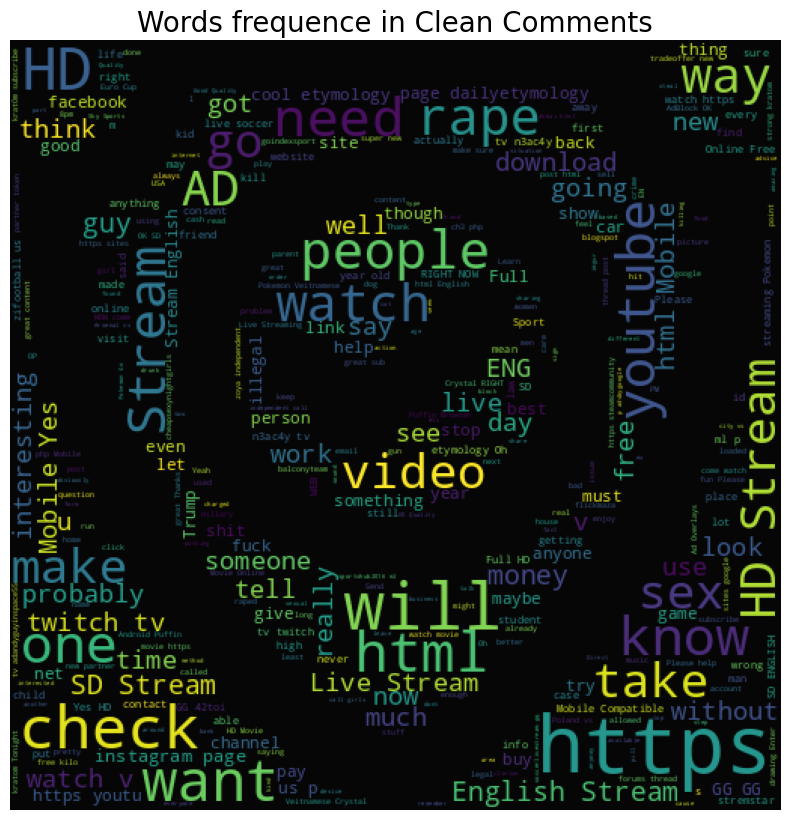

In [14]:
#clean comments
clean_mask=np.array(Image.open("../input/imagesforkernal/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=df_train[df_train.rule_violation==0]
text=subset.body.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequence in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [15]:
def build_input_single_comment(row):
        text = f"""
    You are an expert moderator bot for Reddit. 
    Your task is to accurately determine whether a given Reddit comment violates a specific subreddit rule. 
    You will be provided with the subreddit name and the rule. 
    Analyze the comment carefully in the context of the provided rule and subreddit name. 
    Your final response MUST be either 'Yes' or 'No'. A 'Yes' indicates a clear violation, and a 'No' indicates no violation.    
    
    Subreddit: r/{row.subreddit}
    Rule: {row.rule}

    **Analyze the following comment:**
        
        Comment: {row.body}
        Violation:
    """
        return text
    
#id2label = {0:"No violation",1:"Rule Violation"}
def build_input(row):
    text = f"""
    r/{row.subreddit}
    Rule: {row.rule}
    
    1) {row.positive_example_1}
    Violation: Yes
    
    2) {row.positive_example_2}
    Violation: Yes
    
    3) {row.negative_example_1}
    Violation: No
    
    4) {row.negative_example_2}
    Violation: No
    
    You have to predict if the comment below violate the rule of Reddit :
    5) {row.body}
    """
    
    return text
if not COMPETITION:   
    df_train["input"] = df_train.apply(build_input, axis=1)
df_test["input"] = df_test.apply(build_input, axis=1)

## 3. Model Architecture: The Hybrid Approach
To balance **reasoning** (LLMs) with **robustness** (Encoders) and **context** (Retrieval), this solution utilizes a 3-part weighted ensemble.

### A. Reasoner: Qwen 0.6B (GPTQ-Int8)
* **Role:** Classification based on instruction-following capability.
* **Path:** `/kaggle/input/qwen-3/transformers/0.6b-gptq-int8/1`
* **Tech:** Fine-tuned using **QLoRA** and optimized with **vLLM** for latency.

### B. Retriever (RAG): Qwen-Embedding 0.6B
* **Role:** Contextual understanding via similarity search.
* **Path:** `/kaggle/input/qwen-3-embedding/transformers/0.6b/1`
* **Mechanism:** We embed the entire training set. For every test comment, we retrieve the **Top-K (10)** most similar past examples. If the retrieved neighbors are violations, the model assigns a high probability of violation to the new comment. This acts as a "memory" of past moderation decisions.

### C. Baseline: DeBERTa-v3
* **Role:** Lightweight discriminative classifier for rapid iteration.
* **Weight:** Assigned a lower weight in the final ensemble due to lower accuracy compared to the generative/retrieval methods.

In [17]:
# DeBERTa Model Definition
model_nm = "/kaggle/input/deberta-v3-base/transformers/default/1"
save_path = '/kaggle/input/full_continuous_prompt/tensorflow2/default/1/microsoft/deberta-v3-small_fine_tuned'
save_base = "/kaggle/input/deberta-v3-base/transformers/default/1/deberta-v3-base"

def tok_func(x, my_tokz=None): return tokz(x["input"]) if not my_tokz else my_tokz(x["input"])
if COMPETITION:
    tokz = AutoTokenizer.from_pretrained(save_path)
else:
    tokz = AutoTokenizer.from_pretrained(save_base)
    print(tokz)
    tok_ds = ds.map(tok_func, batched=True)
    tok_ds = tok_ds.rename_columns({"rule_violation":"labels"})

# Prepare Test Data
eval_ds = Dataset.from_pandas(df_test)
ds = Dataset.from_pandas(df_train)
toks_eval_ds = eval_ds.map(tok_func, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

## 4. Training Pipeline & Validation Strategy
* **Validation:** A **Stratified Group K-Fold** split (k=4) is used to ensure no data leakage between subreddits. This mimics the production scenario where the model must generalize to unseen communities.
* **Loss Function:** Cross-Entropy with class weighting to handle the imbalance between violating and non-violating comments.

In [18]:
if not COMPETITION:
    dds = tok_ds.train_test_split(0.25, seed=42) # Put in your validation set message (body) never seen
    dds

In [19]:
def auc(eval_pred):
    print("evalpred",eval_pred)
    preds, labels = eval_pred
    # Apply softmax across the 2 logits → take probability of class 1
    exp_preds = np.exp(preds - np.max(preds, axis=1, keepdims=True))  # stability trick
    probs = exp_preds[:, 1] / exp_preds.sum(axis=1, keepdims=True)[:, 0]

    # Compute AUC only if both classes are present
    if len(np.unique(labels)) > 1:
        auc = roc_auc_score(labels, probs)
    else:
        auc = 0.0

    return {"AUC": auc}

In [20]:
bs = 16
epochs = 3
lr = 8e-5
def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column('rule_violation', 'labels')
    tok_ds = ds.map(tok_func, batched=True)
    return tok_ds

def get_model():
    if COMPETITION:
        model = AutoModelForSequenceClassification.from_pretrained(save_path)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(save_base)
    return model

def get_trainer(dds=None, model=None,is_full_dataset=False):
    if model is None: model = get_model()
    if COMPETITION:
        args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True, 
        per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=0.01, report_to='none')
        return Trainer(model, args,
                  tokenizer=tokz)
    else:
        args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        eval_strategy="epoch" if not is_full_dataset else "no", save_strategy="epoch",load_best_model_at_end=not is_full_dataset, per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2, 
        num_train_epochs=epochs, weight_decay=0.01, report_to='none')
        return Trainer(model, args, train_dataset=dds['train'] if not is_full_dataset else dds, eval_dataset=dds['test'] if not is_full_dataset else None,compute_metrics=auc,
                  tokenizer=tokz)

def get_continuous_probs(preds): # For AUC 
    probs = tf.nn.softmax(preds, axis=-1)[:, 1].numpy() 
    return probs

def get_class_probs(preds):
    probs = tf.math.softmax(preds, axis=-1) 
    probs = tf.argmax(probs, axis=-1)
    return probs

In [21]:
model = get_model()
trainer = get_trainer(dds if not COMPETITION else None, model, is_full_dataset=False)

/tmp/ipykernel_38/1701748705.py:22: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



[2025-11-23 00:56:19,740] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[2025-11-23 00:56:22,874] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [22]:
if not COMPETITION:
    gc.collect()
    torch.cuda.empty_cache()
    trainer.train()

In [23]:
## Run DeBERTa Inference
if COMPETITION:
    preds = trainer.predict(toks_eval_ds).predictions.astype(float)
    probs = get_continuous_probs(preds)
    submission = pd.DataFrame({
        'row_id': eval_ds['row_id'],
        'rule_violation': probs
    })
    submission.to_csv('submission_deberta.csv', index=False)

I0000 00:00:1763859384.298950      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12960 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763859384.299553      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12968 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Cross Validation

In [24]:
def build_input_separate_example(ds, my_tokz=None,use_tokz=True):
    # subreddit, rule, positive_example_i, negative_example_i, rule_violation
    cat = ["positive_example_", "negative_example_"]
    if use_tokz:
        df = ds.to_pandas()
        final_df = df
    else:
        ds.rename(columns={"rule_violation":"labels"}, inplace=True)
        df = ds
        final_df = ds
    for c in cat:
        for i in range(1,3):
            res = df[["subreddit","rule",f"{c}{i}"]]
            res["labels"] = c == "positive_example_"
            res.rename(columns={f"{cat}{i}":"body"})
            final_df = pd.concat([final_df,res], axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(subset=["subreddit","rule","body","labels"])
    if use_tokz:
        final_df["input"] = final_df.apply(build_input_single_comment, axis=1)
        final_df["body"] = final_df.apply(build_input_single_comment, axis=1)
    else:
        final_df["input"] = final_df["body"]
    final_df = final_df.dropna(subset=["labels"],axis=0)
    final_df["labels"] = final_df["labels"].astype("float32")
    if use_tokz:
        ds = Dataset.from_pandas(final_df)
        ds = ds.map(tok_func, batched=True)
        return ds
    else:
        return final_df

In [25]:
n_folds = 4
cv = StratifiedGroupKFold(n_splits=n_folds)
idxs = np.arange(len(df_train))
df_train_mixed = df_train.sample(frac=1, random_state=42)
targets = df_train_mixed.rule_violation
folds = list(cv.split(idxs, targets, df_train_mixed.body))

def get_fold(folds, i):
    trn_idx, val_idx = folds[i]
    return DatasetDict({"train":tok_ds.select(trn_idx), "test":tok_ds.select(val_idx)})

In [26]:
if not COMPETITION:
    oof_preds = np.zeros(len(df_train_mixed))   # to store fold predictions
    preds_arr = []
    oof_labels = df_train_mixed.rule_violation.values
    fold_losses, fold_aucs = [], []
    tok_ds_mixed = get_dds(df_train_mixed)
    gc.collect()
    torch.cuda.empty_cache()
    for i in range(n_folds):
        print(f"===== Fold {i+1} =====")
        gc.collect()
        torch.cuda.empty_cache()
        # Build trainer
        fold = get_fold(folds, i)
        ds = DatasetDict({"train":build_input_separate_example(fold["train"]), "test":build_input_separate_example(fold["test"])})
        #ds = build_input_separate_example(fold[i])
        trainer = get_trainer(ds)
        
        # Train
        trainer.train()
        
        # Evaluate (gives loss and metrics)
        eval_output = trainer.evaluate()
        fold_losses.append(eval_output["eval_loss"])
        if "eval_AUC" in eval_output:   # if your compute_metrics returns {"auc": ...}
            fold_aucs.append(eval_output["eval_AUC"])
        else:
            print("no eval_auc")
            fold_aucs.append(eval_output)
        
        # Predict on validation
        trn_idx, val_idx = folds[i]
        preds = trainer.predict(tok_ds_mixed.select(val_idx)).predictions
        probs = get_continuous_probs(preds)
        
        # Store in OOF
        oof_preds[val_idx] = probs
    df_oof_deberta = pd.DataFrame({"row_id":np.arange(len(oof_preds)), "rule_violation":oof_preds})
    df_oof_deberta.to_csv("oof_preds_deberta.csv")

In [27]:
if not COMPETITION:
    # Average validation loss and AUC
    mean_loss = np.mean(fold_losses)
    mean_auc = np.mean(fold_aucs)
    
    print(f"Mean Val Loss: {mean_loss:.4f}")
    print(f"Mean Val AUC: {mean_auc:.4f}")
    
    
    # # OOF AUC (global, unbiased estimate)
    oof_auc = roc_auc_score(oof_labels, oof_preds)
    print(f"OOF AUC: {oof_auc:.4f}")
    #new_preds = trainer.predict(tok_ds.select(val_idx))

In [28]:
if not COMPETITION:
    df_train = pd.read_csv("/kaggle/input/jigsaw-gui/train.csv")
    df_train["input"] =  df_train.apply(build_input_single_comment, axis=1)
    df_train["rule_violation"] = df_train["rule_violation"].astype("float32")
    ez_ds = Dataset.from_pandas(df_train)
    ez_ds = ez_ds.map(tok_func, batched =True)
    tok_ds = get_dds(df_train)
    all_preds = trainer.predict(ez_ds).predictions.astype(float)
    #all_probs = get_continuous_probs(all_preds)
    all_probs = 1 / (1 + np.exp(-all_preds.reshape(-1)))
    all_auc = roc_auc_score(tok_ds["labels"], all_probs)
    print(all_auc)

### RAG Embedding Qwen3 

In [29]:
EMBDEDDING_MODEL_PATH = "/kaggle/input/qwen-3-embedding/transformers/0.6b/1"
MODEL_OUTPUT_PATH = '/kaggle/input/qwen3-8b-embedding'
EMBEDDING_MODEL_QUERY = "Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery:"

CLEAN_TEXT = True
TOP_K = 1000
BATCH_SIZE = 64


tokz_embedding = AutoTokenizer.from_pretrained(EMBDEDDING_MODEL_PATH)


def build_prompt_embedding(row):
    return f"""r/{row["subreddit"]}\nComment: {row["body"]}"""


def cleaner(text):
    return clean(
        text,
        fix_unicode=True,
        to_ascii=True,
        lower=False,
        no_line_breaks=False,
        no_urls=True,
        no_emails=False,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=False,
        no_punct=False,
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        lang="en",
    )

def is_meaningful_token(token, digit_ratio_threshold=0.5):
    if token.isdigit():
        return False
    digit_count = sum(c.isdigit() for c in token)
    if digit_count / len(token) > digit_ratio_threshold:
        return False
    return True

def extract_urls(text):
    if pd.isna(text):
        return "", ""
    # markdown url : [anchor](url)
    markdown_pattern = re.compile(
        r"\[([^\]]+)\]\(((?:https?://|www\.)[A-Za-z0-9\.-]+(?:/[A-Za-z0-9_\-./]*)?|[A-Za-z0-9\.-]+\.[A-Za-z]{2,}(?:/[A-Za-z0-9_\-./]*)?)\)"
    )
    match = markdown_pattern.search(text)
    if match:
        anchor_text, url = match.groups()
        text_without_urls = markdown_pattern.sub(anchor_text, text)
        return url, text_without_urls.strip()
    # url
    pattern = re.compile(
        r"(https?://[A-Za-z0-9\.-]+(?:/[A-Za-z0-9_\-./]*)?|www\.[A-Za-z0-9\.-]+(?:/[A-Za-z0-9_\-./]*)?)"
    )
    match = pattern.search(text)
    if match:
        url = match.group(1)
        text_without_urls = pattern.sub("", text)
        return url, text_without_urls.strip()
    return "", text.strip()

def url_to_semantics(url):
    if not url:
        return ""
    semantics = []
    seen = set()
    url_lower = url.lower()
    # domain
    domain_match = re.search(r"(?:https?://)?([a-z0-9\-\.]+)\.[a-z]{2,}", url_lower)
    if domain_match:
        full_domain = domain_match.group(1)
        parts = full_domain.split(".")
        for part in parts:
            if part and part not in seen and len(part) > 3 and is_meaningful_token(part):
                semantics.append(part)
                seen.add(part)
    # datatime
    date_match = re.search(r"/(20\d{2})/(\d{2})/(\d{2})/", url_lower)
    if date_match:
        semantics.append(
            f"year:{date_match.group(1)} month:{date_match.group(2)} day:{date_match.group(3)}"
        )
    # path
    path = re.sub(r"^(?:https?://)?[a-z0-9\.-]+\.[a-z]{2,}", "", url_lower)
    path_parts = [p for p in re.split(r"/+", path) if p]
    for part in path_parts:
        part_clean = re.sub(r"\.html?$", "", part)
        if part_clean and part_clean not in seen and is_meaningful_token(part_clean):
            semantics.append(part_clean)
            seen.add(part_clean)
    return " ".join(semantics)

def get_dataframe_to_train_embedding(data_path, append_url_keywords=True, train_dataset=None, test_dataset=None):
    if train_dataset is None:
        train_dataset = pd.read_csv(f"{data_path}/train.csv")
    if test_dataset is None:
        test_dataset = pd.read_csv(f"{data_path}/test.csv")
    train_df = build_input_separate_example(train_dataset, use_tokz=False)
    test_df = build_input_separate_example(test_dataset, use_tokz=False)
    test_df = test_df[test_df["labels"].notna()]
    dataframe = pd.concat([train_df,test_df], axis=0)
    if append_url_keywords:
        urls_and_texts = dataframe["body"].apply(extract_urls)
        dataframe["body_url"] = urls_and_texts.apply(lambda x: x[0])
        dataframe["body"] = urls_and_texts.apply(lambda x: x[1])
        dataframe["body_key"] = dataframe["body_url"].apply(lambda u: url_to_semantics(u) if u else "")
        dataframe["body"] = dataframe.apply(
            lambda row: row["body"] + (" " + row["body_key"] if row["body_key"] else ""),
            axis=1,
        )
    return dataframe


def prepare_dataframe(dataframe):
    dataframe["prompt"] = dataframe.apply(build_prompt_embedding, axis=1)

    
    if CLEAN_TEXT:
        tqdm.pandas(desc="cleaner")
        dataframe["prompt"] = dataframe["prompt"].progress_apply(cleaner)

    if "labels" in dataframe.columns:
        dataframe["labels"] = dataframe["labels"].map(
            {
                1: 1,
                0: -1,
            }
        )
        

    return dataframe

In [30]:
%%writefile infer_qwen_url.py

import os
import pandas as pd
from logits_processor_zoo.vllm import MultipleChoiceLogitsProcessor
import torch
import vllm
import numpy as np
from vllm.lora.request import LoRARequest
import argparse
from scipy.special import softmax
df = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")

MODEL_NAME = "/kaggle/input/qwen-3/transformers/0.6b-gptq-int8/1"

if __name__=='__main__':
    os.environ["VLLM_USE_V1"] = "0"

    llm = vllm.LLM(
        MODEL_NAME,
        # quantization='awq',
        quantization='gptq',
        tensor_parallel_size=torch.cuda.device_count(),
        gpu_memory_utilization=0.98,
        trust_remote_code=True,
        dtype="half",
        enforce_eager=True,
        max_model_len=2836,
        disable_log_stats=True,
        enable_prefix_caching=True,
        enable_lora=False,
        max_lora_rank=32
    )
    tokenizer = llm.get_tokenizer()
    SYS_PROMPT = """
You are given a comment on reddit. Your task is to classify if it violates the given rule. Only respond Yes/No.
"""
    
    prompts = []
    for i, row in df.iterrows():
        text = f"""
    r/{row.subreddit}
    Rule: {row.rule}
    
    1) {row.positive_example_1}
    Violation: Yes
    
    2) {row.positive_example_2}
    Violation: Yes
    
    3) {row.negative_example_1}
    Violation: No
    
    4) {row.negative_example_2}
    Violation: No
    
    5) {row.body}
    """
        
        messages = [
            {"role": "system", "content": SYS_PROMPT},
            {"role": "user", "content": text}
        ]
    
        prompt = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=False,
        ) + "Answer:"
        prompts.append(prompt)
    
    df["prompt"] = prompts
    
    mclp = MultipleChoiceLogitsProcessor(tokenizer, choices=['Yes','No'])
    outputs = llm.generate(
        prompts,
        vllm.SamplingParams(
            skip_special_tokens=True,
            max_tokens=1,
            logits_processors=[mclp],
            logprobs=2,
        ),
        use_tqdm=True,
    )
    logprobs = [
        {lp.decoded_token: lp.logprob for lp in out.outputs[0].logprobs[0].values()}
        for out in outputs
    ]
    logit_matrix = pd.DataFrame(logprobs)[['Yes','No']]
    df = pd.concat([df, logit_matrix], axis=1)
    
    df[['Yes',"No"]] = df[['Yes',"No"]].apply(lambda x: softmax(x.values), axis=1, result_type="expand")
    df["pred"] = df["Yes"]
    df['rule_violation'] = df["pred"]
    df[['row_id', 'rule_violation']].to_csv("submission_qwen_url.csv",index=False)
    res = pd.read_csv('submission_qwen_test_url.csv')
    display(res)

Overwriting infer_qwen_url.py


In [31]:
def get_scores(test_dataframe, corpus_dataframe=None):
    if corpus_dataframe is None:
        corpus_dataframe = get_dataframe_to_train_embedding(DATA_PATH)
    corpus_dataframe = prepare_dataframe(corpus_dataframe)
    # Load base model
    model = AutoModelForCausalLM.from_pretrained(EMBDEDDING_MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(EMBDEDDING_MODEL_PATH)
    embedding_model = SentenceTransformer(
        model_name_or_path=EMBDEDDING_MODEL_PATH,
        device="cuda",
    )

    print('Done loading model!')

    result = []
    for rule in tqdm(test_dataframe["rule"].unique(), desc=f"Generate scores for each rule"):
        test_dataframe_part = test_dataframe.query("rule == @rule").reset_index(drop=True).copy()
        corpus_dataframe_part = corpus_dataframe.query("rule == @rule").reset_index(drop=True).copy()
        if ("row_id" in corpus_dataframe_part):
            corpus_dataframe_part = corpus_dataframe_part.drop(columns=["row_id"])
        corpus_dataframe_part = corpus_dataframe_part.reset_index(names="row_id")
        
        query_embeddings = embedding_model.encode(
            sentences=test_dataframe_part["prompt"].tolist(),
            prompt=EMBEDDING_MODEL_QUERY,
            batch_size=BATCH_SIZE,
            show_progress_bar=True,
            convert_to_tensor=True,
            device="cuda",
            normalize_embeddings=True,
        )
        document_embeddings = embedding_model.encode(
            sentences=corpus_dataframe_part["prompt"].tolist(),
            batch_size=BATCH_SIZE,
            show_progress_bar=True,
            convert_to_tensor=True,
            device="cuda",
            normalize_embeddings=True,
        )
        test_dataframe_part["semantic"] = semantic_search(
            query_embeddings,
            document_embeddings,
            top_k=TOP_K,
            score_function=dot_score,
        )
        def get_score(semantic):
            semantic = pd.DataFrame(semantic)
            semantic = semantic.merge(
                corpus_dataframe_part[["row_id", "labels"]],
                how="left",
                left_on="corpus_id",
                right_on="row_id",
            )
            semantic["score"] = semantic["score"]*semantic["labels"]
            return semantic["score"].sum()
            
        tqdm.pandas(desc=f"Add label for {rule=}")
        test_dataframe_part["labels"] = test_dataframe_part["semantic"].progress_apply(get_score)
        result.append(test_dataframe_part[["row_id", "labels"]].copy())
        
    submission = pd.concat(result, axis=0)
    return submission


def generate_submission_embedding():
    test_dataframe = pd.read_csv(f"{DATA_PATH}/test.csv")
    test_dataframe = prepare_dataframe(test_dataframe)
    
    submission = get_scores(test_dataframe)
    submission = test_dataframe[["row_id"]].merge(submission, on="row_id", how="left")
    submission = submission.rename(columns={"labels":"rule_violation"})
    submission.to_csv("submission_embedding.csv", index=False)

def evaluate_on_train():
    """
    Applique le pipeline get_scores() sur les données d'entraînement
    et calcule l'AUC pour mesurer les performances.
    """
    # 1. Charger et préparer les données train
    train_dataframe = pd.read_csv(f"{DATA_PATH}/train.csv")
    train_dataframe = prepare_dataframe(train_dataframe)

    # 2. Générer les prédictions (même logique que pour le test)
    preds = get_scores(train_dataframe)

    # 3. Fusionner avec les vraies étiquettes
    train_eval = train_dataframe[["row_id", "labels","body"]].merge(
        preds, on="row_id", how="left", suffixes=("_true", "_pred")
    )
    
    # 4. Calcul de l’AUC (probas continues attendues dans `_pred`)
    auc = roc_auc_score(train_eval["labels_true"], train_eval["labels_pred"])

    print(f"Validation AUC on train set: {auc:.4f}")

    return train_eval, auc

def get_oof_predictions_embedding(n_folds=4):
    """
    Calcule les prédictions OOF et l'AUC.
    """
    df_train = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
    n_folds = 4
    cv = StratifiedGroupKFold(n_splits=n_folds,shuffle=True, random_state=42)
    idxs = np.arange(len(df_train))
    targets = df_train.rule_violation
    folds = list(cv.split(idxs, targets, df_train.body))
    oof_preds = np.zeros(len(df_train))
    oof_labels = df_train["rule_violation"].values
    gc.collect()
    torch.cuda.empty_cache()
    for i in range(n_folds):
        print(f"\n===== Fold {i+1}/{n_folds} =====")
        trn_idx, val_idx = folds[i]
        
        # Split in corpus (train fold) and validation
        df_trn = df_train.iloc[trn_idx].reset_index(drop=True)
        df_val = df_train.iloc[val_idx].reset_index(drop=True)

        # Build input in dataframe
        dataframe = get_dataframe_to_train_embedding("nopath",append_url_keywords=False, train_dataset=df_trn, test_dataset=df_val)
        df_val = prepare_dataframe(df_val)
        # Prédire sur la validation en utilisant uniquement le corpus du train fold
        preds_val = get_scores(df_val, corpus_dataframe=dataframe)

        # Merge avec row_id pour bien aligner
        df_val = df_val[["row_id"]].merge(preds_val, on="row_id", how="left")

        # Remplir le vecteur OOF
        oof_preds[val_idx] = df_val["labels"].values

        print(f"AUC Fold {i} : {roc_auc_score(oof_labels[val_idx], oof_preds[val_idx])} ")
        gc.collect()
        torch.cuda.empty_cache()

    # Score global OOF
    auc = roc_auc_score(oof_labels, oof_preds)
    print(f"\nOOF AUC: {auc:.4f}")

    return oof_preds, auc


In [32]:
gc.collect()
torch.cuda.empty_cache()
generate_submission_embedding()

cleaner:   0%|          | 0/10 [00:00<?, ?it/s]

cleaner:   0%|          | 0/2317 [00:00<?, ?it/s]

Done loading model!


Generate scores for each rule:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

Add label for rule='No Advertising: Spam, referral links, unsolicited advertising, and promotional content are…

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Add label for rule='No legal advice: Do not offer or request legal advice.':   0%|          | 0/1 [00:00<?, ?i…

### LLM Fine-Tuning (QLoRA) Configuration
Below we configure the LoRA parameters for efficient training of the Qwen model.

In [33]:
%%writefile utils_lora.py
import pandas as pd
from datasets import Dataset
from constants_lora import POSITIVE_ANSWER, NEGATIVE_ANSWER, COMPLETE_PHRASE, BASE_PROMPT
import random, numpy as np
random.seed(42)
np.random.seed(42)

def build_prompt(row):
    return f"""
{BASE_PROMPT}

Subreddit: r/{row["subreddit"]}
Rule: {row["rule"]}
Examples:
1) {row["positive_example"]}
{COMPLETE_PHRASE} Yes

2) {row["negative_example"]}
{COMPLETE_PHRASE} No

---
Comment: {row["body"]}
{COMPLETE_PHRASE}"""


def get_dataframe_to_train_lora(data_path, train_dataset=None, test_dataset=None):
    train_dataset = pd.read_csv(train_dataset if train_dataset else f"{data_path}/train.csv")
    test_dataset = pd.read_csv(test_dataset if test_dataset else f"{data_path}/test.csv").sample(frac=0.5, random_state=42).reset_index(drop=True)

    flatten = []

    # ---------- Processing the training set ----------
    train_df = train_dataset[["body", "rule", "subreddit", "rule_violation",
                              "positive_example_1","positive_example_2",
                              "negative_example_1","negative_example_2"]].copy()

    # Random selection positive_example and negative_example
    train_df["positive_example"] = np.where(
        np.random.rand(len(train_df)) < 0.5,
        train_df["positive_example_1"],
        train_df["positive_example_2"]
    )
    train_df["negative_example"] = np.where(
        np.random.rand(len(train_df)) < 0.5,
        train_df["negative_example_1"],
        train_df["negative_example_2"]
    )

    # Delete the original candidate column
    train_df.drop(columns=["positive_example_1","positive_example_2",
                           "negative_example_1","negative_example_2"], inplace=True)

    flatten.append(train_df)

    # ---------- Processing the test set ----------
    for violation_type in ["positive", "negative"]:
        for i in range(1, 3):
            sub_dataset = test_dataset[["rule","subreddit",
                                        "positive_example_1","positive_example_2",
                                        "negative_example_1","negative_example_2"]].copy()

            if violation_type == "positive":
                body_col = f"positive_example_{i}"
                other_positive_col = f"positive_example_{3-i}"  # another positive
                sub_dataset["body"] = sub_dataset[body_col]
                sub_dataset["positive_example"] = sub_dataset[other_positive_col]
                sub_dataset["negative_example"] = np.where(
                    np.random.rand(len(sub_dataset)) < 0.5,
                    sub_dataset["negative_example_1"],
                    sub_dataset["negative_example_2"]
                )
                sub_dataset["rule_violation"] = 1

            else:  # violation_type == "negative"
                body_col = f"negative_example_{i}"
                other_negative_col = f"negative_example_{3-i}"
                sub_dataset["body"] = sub_dataset[body_col]
                sub_dataset["negative_example"] = sub_dataset[other_negative_col]
                sub_dataset["positive_example"] = np.where(
                    np.random.rand(len(sub_dataset)) < 0.5,
                    sub_dataset["positive_example_1"],
                    sub_dataset["positive_example_2"]
                )
                sub_dataset["rule_violation"] = 0

            # Delete the original candidate column
            sub_dataset.drop(columns=["positive_example_1","positive_example_2",
                                      "negative_example_1","negative_example_2"], inplace=True)

            flatten.append(sub_dataset)

    # Merge All DataFrame
    dataframe = pd.concat(flatten, axis=0)
    dataframe = dataframe.drop_duplicates(ignore_index=True)

    return dataframe

def build_dataset_lora(dataframe):
    dataframe["prompt"] = dataframe.apply(build_prompt, axis=1)

    columns = ["prompt"]
    if "rule_violation" in dataframe:
        dataframe["completion"] = dataframe["rule_violation"].map(
            {
                1: POSITIVE_ANSWER,
                0: NEGATIVE_ANSWER,
            }
        )
        columns.append("completion")

    dataframe = dataframe[columns]
    dataset = Dataset.from_pandas(dataframe)
    dataset.to_pandas().to_csv("/kaggle/working/dataset.csv", index=False)
    return dataset

Overwriting utils_lora.py


In [34]:
%%writefile train_lora.py
import pandas as pd
import argparse
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from tqdm.auto import tqdm
from transformers.utils import is_torch_bf16_gpu_available
from utils_lora import build_dataset_lora, get_dataframe_to_train_lora
from constants_lora import DATA_PATH, BASE_MODEL_PATH, LORA_PATH


def main(train_dataset, test_dataset):
    if train_dataset and test_dataset:
        dataframe = get_dataframe_to_train_lora("", train_dataset=train_dataset, test_dataset=test_dataset)
    else:
        dataframe = get_dataframe_to_train_lora(DATA_PATH)
    train_dataset = build_dataset_lora(dataframe)
    
    lora_config = LoraConfig(
            r=16,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
            task_type="CAUSAL_LM",
        )
        
    training_args = SFTConfig(
        num_train_epochs=1,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        
        optim="paged_adamw_8bit",
        learning_rate=1e-4, #keep high, lora usually likes high. 
        weight_decay=0.01,
        max_grad_norm=1.0,
        
        lr_scheduler_type="cosine",
        warmup_ratio=0.03,
        
        bf16=is_torch_bf16_gpu_available(),
        fp16=not is_torch_bf16_gpu_available(),
        dataloader_pin_memory=True,
        
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
    
        save_strategy="no",
        report_to="none",
    
        completion_only_loss=True,
        packing=False,
        remove_unused_columns=False,
    )
        
    trainer = SFTTrainer(
        BASE_MODEL_PATH,
        args=training_args,
        train_dataset=train_dataset,
        peft_config=lora_config,
    )
    trainer.train()
    trainer.save_model(LORA_PATH)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--train_dataset", type=str, required=False)
    parser.add_argument("--test_dataset", type=str, required=False)
    args = parser.parse_args()
    main(args.train_dataset, args.test_dataset)

Overwriting train_lora.py


In [35]:
%%writefile inference_lora.py
import os
os.environ["VLLM_USE_V1"] = "0"

import argparse
import gc
import vllm
import torch
import pandas as pd
from logits_processor_zoo.vllm import MultipleChoiceLogitsProcessor
from vllm.lora.request import LoRARequest
from constants_lora import BASE_MODEL_PATH, LORA_PATH, DATA_PATH, POSITIVE_ANSWER, NEGATIVE_ANSWER, COMPLETE_PHRASE, BASE_PROMPT
from datasets import Dataset
from utils_lora import build_dataset_lora
from constants_lora import BASE_MODEL_PATH, LORA_PATH, DATA_PATH, POSITIVE_ANSWER, NEGATIVE_ANSWER
import random
import multiprocessing as mp

def worker(device_id, df_slice, return_dict):
    # Limit the process to only see one GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = str(device_id)
    print(f"[Worker {device_id}] Running on GPU {device_id}, data size={len(df_slice)}")
    
    preds = run_inference_on_device(df_slice)
    print(f"Worker {device_id} : preds {preds}")
    return_dict[device_id] = preds
    
def run_inference_on_device(df_slice):
    """Visible to the current process GPU Run up vLLM reasoning"""
    llm = vllm.LLM(
        BASE_MODEL_PATH,
        quantization="gptq",
        tensor_parallel_size=1,
        gpu_memory_utilization=0.98,
        trust_remote_code=True,
        dtype="half",
        enforce_eager=True,
        max_model_len=2836,
        disable_log_stats=True,
        enable_prefix_caching=True,
        enable_lora=True,
        max_lora_rank=64,
    )

    tokenizer = llm.get_tokenizer()
    mclp = MultipleChoiceLogitsProcessor(tokenizer, choices=[POSITIVE_ANSWER, NEGATIVE_ANSWER])

    test_dataset = build_dataset_lora(df_slice)
    texts = test_dataset["prompt"]

    outputs = llm.generate(
        texts,
        vllm.SamplingParams(
            skip_special_tokens=True,
            max_tokens=1,
            logits_processors=[mclp],
            logprobs=2,
        ),
        use_tqdm=True,
        lora_request=LoRARequest("default", 1, LORA_PATH)
    )

    log_probs = [
        {lp.decoded_token: lp.logprob for lp in out.outputs[0].logprobs[0].values()}
        for out in outputs
    ]
    predictions = pd.DataFrame(log_probs)[[POSITIVE_ANSWER, NEGATIVE_ANSWER]]
    predictions["row_id"] = df_slice["row_id"].values
    return predictions

def build_test_df_lora(test_dataframe):
    # Randomly select examples
    test_dataframe["positive_example"] = test_dataframe.apply(
        lambda row: random.choice([row["positive_example_1"], row["positive_example_2"]]),
        axis=1
    )
    test_dataframe["negative_example"] = test_dataframe.apply(
        lambda row: random.choice([row["negative_example_1"], row["negative_example_2"]]),
        axis=1
    )
    test_dataframe = test_dataframe.drop(
        columns=["positive_example_1", "positive_example_2", "negative_example_1", "negative_example_2"],
        errors="ignore"
    )
    return test_dataframe




def main(test_dataset):
    gc.collect()
    torch.cuda.empty_cache()
    test_dataframe = pd.read_csv(test_dataset if test_dataset else  f"{DATA_PATH}/test.csv")
    print("len test_dataset",len(test_dataframe))
    test_dataframe = build_test_df_lora(test_dataframe)
    # Splitting data
    mid = len(test_dataframe) // 2
    df0 = test_dataframe.iloc[:mid].reset_index(drop=True)
    df1 = test_dataframe.iloc[mid:].reset_index(drop=True)
    
    manager = mp.Manager()
    return_dict = manager.dict()
    
    
    # Two processes in paralell
    p0 = mp.Process(target=worker, args=(0, df0, return_dict))
    p1 = mp.Process(target=worker, args=(1, df1, return_dict))
    p0.start()
    p1.start()
    p0.join()
    p1.join()
    
    # # Merge results
    predictions = pd.concat([return_dict[0], return_dict[1]], ignore_index=True)
    
    # Build submission
    submission = predictions[["row_id", POSITIVE_ANSWER]].rename(columns={POSITIVE_ANSWER: "rule_violation"})
    rl = submission['rule_violation'].rank(method='average') / (len(submission) + 1)
    submission['rule_violation'] = rl
    
    submission.to_csv("submission_lora.csv", index=False)
    print("✅ Saved submission_lora.csv")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--test_dataset", type=str, required=False)
    args = parser.parse_args()
    main(args.test_dataset)

Overwriting inference_lora.py


In [36]:
%%writefile accelerate_config.yaml
compute_environment: LOCAL_MACHINE
debug: false
deepspeed_config:
  gradient_accumulation_steps: 4
  gradient_clipping: 1.0
  train_batch_size: 64
  train_micro_batch_size_per_gpu: 4
  
  zero_stage: 2
  offload_optimizer_device: none
  offload_param_device: none
  zero3_init_flag: false
  
  stage3_gather_16bit_weights_on_model_save: false
  stage3_max_live_parameters: 1e8
  stage3_max_reuse_distance: 1e8
  stage3_prefetch_bucket_size: 5e7
  stage3_param_persistence_threshold: 1e5
  
  zero_allow_untested_optimizer: true
  zero_force_ds_cpu_optimizer: false
  
  fp16:
    enabled: true
    loss_scale: 0
    initial_scale_power: 16
    loss_scale_window: 1000
    hysteresis: 2
    min_loss_scale: 1
  
distributed_type: DEEPSPEED
downcast_bf16: 'no'
dynamo_config:
  dynamo_backend: INDUCTOR
  dynamo_use_fullgraph: false
  dynamo_use_dynamic: false
enable_cpu_affinity: false
machine_rank: 0
main_training_function: main
mixed_precision: fp16
num_machines: 1
num_processes: 2
rdzv_backend: static
same_network: true
tpu_env: []
tpu_use_cluster: false
tpu_use_sudo: false
use_cpu: false

Overwriting accelerate_config.yaml


In [37]:
gc.collect()
torch.cuda.empty_cache()
!accelerate launch --config_file accelerate_config.yaml train_lora.py
gc.collect()
torch.cuda.empty_cache()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[2025-11-23 00:57:23,607] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-11-23 00:57:25,294] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False
2025-11-23 00:57:25.571736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763859445.594261     303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763859445.601650     303 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W1123 00:57:28.508000 303 torch/distributed/run.py:766] 
W1123 00:57:28.508000 303 torch/distributed/run.py:766] *****************************************
W1123 00:57:28.508000 303 torc

In [38]:
!python inference_lora.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


len test_dataset 10
[Worker 0] Running on GPU 0, data size=5
[Worker 1] Running on GPU 1, data size=5
2025-11-23 01:09:27.072814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-23 01:09:27.072899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763860167.096503     498 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763860167.096510     496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763860167.103151     496 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for p

In [39]:
def get_oof_predictions_lora(n_folds=4):
    """
    Calcule les prédictions OOF et l'AUC.
    """
    df_train = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
    n_folds = 4
    cv = StratifiedGroupKFold(n_splits=n_folds,shuffle=True, random_state=42)
    idxs = np.arange(len(df_train))
    targets = df_train.rule_violation
    folds = list(cv.split(idxs, targets, df_train.body))
    oof_preds = np.zeros(len(df_train))
    oof_labels = df_train["rule_violation"].values
    gc.collect()
    torch.cuda.empty_cache()
    for i in range(n_folds):
        print(f"\n===== Fold {i+1}/{n_folds} =====")
        trn_idx, val_idx = folds[i]
        
        # Split in corpus (train fold) and validation
        df_trn = df_train.iloc[trn_idx].reset_index(drop=True)
        df_val = df_train.iloc[val_idx].reset_index(drop=True)
        trn_path = f"/kaggle/working/train_fold_{i}.csv"
        val_path = f"/kaggle/working/val_fold_{i}.csv"
        df_trn.to_csv(trn_path)
        df_val.to_csv(val_path)
        !accelerate launch --config_file accelerate_config.yaml train_lora.py --train_dataset {trn_path} --test_dataset {val_path}
        !python inference_lora.py --test_dataset {val_path}
        preds_val = pd.read_csv("/kaggle/working/submission_lora.csv")
        # Merge avec row_id pour bien aligner
        df_val = df_val[["row_id"]].merge(preds_val, on="row_id", how="left")

        # Remplir le vecteur OOF
        oof_preds[val_idx] = df_val["rule_violation"].values

        print(f"AUC Fold {i} : {roc_auc_score(oof_labels[val_idx], oof_preds[val_idx])} ")
        gc.collect()
        torch.cuda.empty_cache()

    # Score global OOF
    auc = roc_auc_score(oof_labels, oof_preds)
    print(f"\nOOF AUC: {auc:.4f}")

    return oof_preds, auc
if not COMPETITION:
    oof_preds, auc = get_oof_predictions_lora(n_folds=4)
    oof_preds_lora, auc_lora = get_oof_predictions_lora()
    df_oof_lora = pd.DataFrame(
        {"row_id":np.arange(len(oof_preds_lora)), "rule_violation":oof_preds_lora})
    df_oof_lora.to_csv("oof_preds_lora.csv")

## 5. Ensemble Optimization (Optuna)
To determine the optimal contribution of each model, I started with a simple grid search baseline to explore the ensemble weight space. To scale this more efficiently, I switched to **Optuna** for Bayesian Optimization. The objective was to maximize validation AUC by finding the perfect weighted average.

**Models & Logic:**
1.  **Qwen-0.6b-GPTQ (LLM):** High weight due to reasoning power.
2.  **Qwen-Embedding (RAG):** High weight due to context retrieval capabilities.
3.  **DeBERTa-v3:** Lower weight, acting as a regularizer.

**Objective:** $Maximize(AUC_{val})$
$$Prediction = w_1 \cdot P(LLM) + w_2 \cdot P(RAG) + w_3 \cdot P(DeBERTa)$$

In [40]:
# Ranks normalized in [0,1]
if COMPETITION:
    l = pd.read_csv("/kaggle/working/submission_lora.csv")
    e = pd.read_csv("/kaggle/working/submission_embedding.csv")
    d = pd.read_csv("/kaggle/working/submission_deberta.csv")
else:
    l = pd.read_csv("/kaggle/working/oof_preds_lora.csv")
    e = pd.read_csv("/kaggle/working/oof_preds_embedding.csv")
    d = pd.read_csv("/kaggle/working/oof_preds_deberta.csv")
rl = l['rule_violation'].rank(method='average') / (len(l) + 1)
re = e['rule_violation'].rank(method='average') / (len(e) + 1)
rd = d['rule_violation'].rank(method='average') / (len(d) + 1)

if not COMPETITION: 
    y_true = df_train["rule_violation"].values  
    best_auc = -1
    best_weights = None
    granularity = 0.1
    grid = np.arange(0, 1 + granularity, granularity)
    for w1 in grid:
        for w2 in grid:
            w3 = 1 - w1 - w2
            if w3 < 0:  # skip invalid combinations
                continue
            s = w1 * rl + w2 * re + w3 * rd
            auc = roc_auc_score(y_true, s)
            if auc > best_auc:
                best_auc = auc
                best_weights = (w1, w2, w3)
    print("best auc BF Method", best_auc)
    print("best weights BF method", best_weights)
    
    
    
    
    def objective(trial):
        # Suggest weights between 0 and 1
        w1 = trial.suggest_float("w1", 0, 1)
        w2 = trial.suggest_float("w2", 0, 1)
        w3 = 1 - w1 - w2  # enforce sum = 1
        
        if w3 < 0:  # invalid combination
            return -1.0  
    
        # Weighted ensemble
        s = w1 * rl + w2 * re + w3 * rd
    
        # Compute AUC
        return roc_auc_score(y_true, s)
    
    # Run optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)  # increase trials for better search
    
    # Best weights
    print("Best trial Optuna Method:", study.best_trial.value)
    print("Best weights Optuna Method:", study.best_params, "w3 =", 1 - study.best_params["w1"] - study.best_params["w2"])

### Ensemble Result

In [ ]:
if COMPETITION:   
    wl = 0.70  
    we = 0.26  
    wd = 0.04 
else:
    wl = study.best_params["w1"] #0.70
    we = study.best_params["w2"] #0.26
    wd = 1 - study.best_params["w1"] - study.best_params["w2"] #0.04 The result of deberta does not provide additional value

blend = wl*rl + we*re + wd*rd 
l["rule_violation"] = blend
l.to_csv('/kaggle/working/submission.csv', index=False)
df_submission = pd.read_csv("/kaggle/working/submission.csv")
display(df_submission)

## 6. Results & Conclusion

### Final Metrics
* **Public Leaderboard AUC:** 0.884
* **Inference Speed:** ~210 samples/sec (enabled by vLLM)

### Key Takeaways for Production
1.  **RAG is Powerful:** Retrieving similar past violations (using Qwen-Embedding) significantly improved robustness compared to pure classification.
2.  **Feature Engineering:** The URL semantic extraction provided a significant lift, proving that domain-specific processing is vital even with LLMs.
3.  **Hybrid Ensembling:** The combined Generative (Qwen) and Retrieval (Embedding) approach outperformed each individual component.

## References
- https://www.kaggle.com/code/hiranorm/offline-install-vllm-0-10-0-i-qwenemdding-llama#3.-Qwen3-0.6b-Embedding
- https://www.kaggle.com/code/kurisew/url-regex-to-keyword#3.-Qwen3-0.6b-Embedding
- https://www.kaggle.com/code/kishanvavdara/test-on-testdataset-qwenemdding-llama-lr